# 4. Model selection

This notebook, part of the analysis phase of the project, is centered around model selection. We will compare the performance on the validation set of BERT for sequence classification and XLnet for sequence classification, to decide which final model we will use on inference.

In [ ]:
# Necessary imports
import emoji

import polars as pl
import sys

import torch

from pathlib import Path

from sklearnex import patch_sklearn
patch_sklearn()

from tqdm import tqdm

from torch.optim import AdamW

from torch.utils.data import (
    DataLoader,
    TensorDataset,
)

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed
from src.utils.model_utils import (
    encode,
    train_model,
    evaluate_model,
    plot_evaluation_report,
)

# Set the seed for reproducibility
rng = set_seed()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
# Directory management
DATA_DIR = ROOT_DIR / "data"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"

MODELS_DIR = ROOT_DIR / "models"

OUTPUT_DIR = ROOT_DIR / "output"
RESULTS_DIR = OUTPUT_DIR / "model_selection"


### 1. Load and process the HateXplain Dataset

In [4]:
# Load the dataframe
df_train = pl.read_parquet(SPLITTED_DATA_DIR / "train_2_classes.parquet")
df_val = pl.read_parquet(SPLITTED_DATA_DIR / "val_2_classes.parquet")
df_test = pl.read_parquet(SPLITTED_DATA_DIR / "test_2_classes.parquet")


In [5]:
# Label encoding
label2id = {"normal": 0, "hatespeech": 1}
id2label = {id_: label for label, id_ in label2id.items()}
target_labels = list(label2id.keys())

df_train = df_train.with_columns(
    pl.col("label").replace_strict(label2id),
)

df_val = df_val.with_columns(
    pl.col("label").replace_strict(label2id),
)


In [6]:
# Create the X, y splits
X_train = df_train["tokens"].to_list()
y_train = df_train["label"].to_list()

X_val = df_val["tokens"].to_list()
y_val = df_val["label"].to_list()

X_test = df_test["tokens"].to_list()


### 2. Evaluate BERT

In [7]:
# Tokenization and encoding
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Search for all the special tokens in the dataset, which are
# characterized by <...>.
special_tokens = set()
for text in X_train + X_val + X_test:
    for word in text:
        if word[0] == "<" and word[-1] == ">":
            special_tokens.add(word)

print(f"Special tokens: {special_tokens}")


Special tokens: {'<laugh>', '<number>', '<percent>', '<tong>', '<date>', '<user>', '<url>', '<censored>', '<sad>', '<email>', '<kiss>', '<time>', '<annoyed>', '<wink>', '<will>', '<money>', '<u200f>', '<surprise>', '<happy>', '<phone>', '<angel>', '<u200d>'}


In [8]:
# Add special tokens to the tokenizer
tokenizer.add_tokens(list(special_tokens))

# The dataset has emojis present in the text. We need to parse them and add them to the tokenizer
emoji_list = [
    word for text in X_train + X_val + X_test for word in text if emoji.is_emoji(word)
]
emoji_list = list(set(emoji_list))

# Add emojis to the tokenizer
for emoji_ in emoji_list:
    tokenizer.add_tokens(emoji_)


In [10]:
# Encode the training and validation datasets
X_train_encoded = encode(X_train, tokenizer)
X_val_encoded = encode(X_val, tokenizer)


In [11]:
# Data preparation
labels_train = torch.tensor(y_train)
labels_val = torch.tensor(y_val)

dataset_train = TensorDataset(
    X_train_encoded["input_ids"],
    X_train_encoded["attention_mask"],
    labels_train,
)

dataset_val = TensorDataset(
    X_val_encoded["input_ids"],
    X_val_encoded["attention_mask"],
    labels_val,
)

batch_size = 32
train_dataloader = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)



In [12]:
# Load the classification model
model_clf = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(target_labels),
)

# Resize the token embeddings to account for the new "<user>" and emoji tokens
model_clf.resize_token_embeddings(len(tokenizer))

# Model configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clf.to(device)

if model_clf.device.type == "cuda":
    print("Successfully loaded the model to the GPU.")
else:
    print("WARNING: Could not load the model to the GPU. Using CPU instead.")


model_clf.config.label2id = label2id
model_clf.config.id2label = id2label

torch.multiprocessing.set_start_method("spawn", force=True)


2025-04-03 14:02:10.732754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 14:02:10.741552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 14:02:10.750079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 14:02:10.753036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 14:02:10.761410: I tensorflow/core/platform/cpu_feature_guar

Successfully loaded the model to the GPU.


In [13]:
# Hyperparameters
learning_rate = 2.e-5
epochs = 5

optimizer = AdamW(model_clf.parameters(), lr=learning_rate, weight_decay=0.1)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps,
)


In [14]:
# Training loop
train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
    model_clf,
    tokenizer,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    epochs=epochs,
    device=device,
    out_dir = RESULTS_DIR / "bert-base-uncased_2_classes",
    model_name="bert",
    monitor="loss",
)


Epoch 1/5: 100%|██████████| 387/387 [03:27<00:00,  1.86batch/s, train_loss=0.423, val_loss=0.375, val_f1=0.834]


Validation loss improved from  inf to  0.375. Saving model...
Model saved to /home/marc/GitHub/MScThesisDS/msc_thesis_ds/.output/model_selection/bert-base-uncased_2_classes
Epoch 1/5 | Train Loss: 0.422929 | Train F1: 0.7649 | Val Loss: 0.375239 | Val F1: 0.8338



Epoch 2/5: 100%|██████████| 387/387 [03:30<00:00,  1.84batch/s, train_loss=0.246, val_loss=0.303, val_f1=0.858]


Validation loss improved from  0.375 to  0.303. Saving model...
Model saved to /home/marc/GitHub/MScThesisDS/msc_thesis_ds/.output/model_selection/bert-base-uncased_2_classes
Epoch 2/5 | Train Loss: 0.245565 | Train F1: 0.8915 | Val Loss: 0.302770 | Val F1: 0.8581



Epoch 3/5: 100%|██████████| 387/387 [03:31<00:00,  1.83batch/s, train_loss=0.15, val_loss=0.38, val_f1=0.86]


Validation loss did not improve from -inf. Not saving model.
Epoch 3/5 | Train Loss: 0.150137 | Train F1: 0.9395 | Val Loss: 0.379939 | Val F1: 0.8603



Epoch 4/5: 100%|██████████| 387/387 [03:31<00:00,  1.83batch/s, train_loss=0.0835, val_loss=0.433, val_f1=0.864]


Validation loss did not improve from -inf. Not saving model.
Epoch 4/5 | Train Loss: 0.083480 | Train F1: 0.9682 | Val Loss: 0.432513 | Val F1: 0.8636



Epoch 5/5: 100%|██████████| 387/387 [03:31<00:00,  1.83batch/s, train_loss=0.0508, val_loss=0.497, val_f1=0.861]

Validation loss did not improve from -inf. Not saving model.
Epoch 5/5 | Train Loss: 0.050800 | Train F1: 0.9818 | Val Loss: 0.496812 | Val F1: 0.8607



In [15]:
# Load the best model
model_clf = AutoModelForSequenceClassification.from_pretrained(
    RESULTS_DIR / "bert-base-uncased_2_classes",
    num_labels=len(target_labels),
)

model_clf.to(device)
if model_clf.device.type == "cuda":
    print("Successfully loaded the model to the GPU.")
else:
    print("WARNING: Could not load the model to the GPU. Using CPU instead.\nErrors may occur.")

# Evaluation of the model on the validation set
correct, total, all_predictions, all_labels, all_probabilities = evaluate_model(
    model_clf,
    val_dataloader,
    device=device,
)


Successfully loaded the model to the GPU.


Running validation: 100%|██████████| 43/43 [00:07<00:00,  5.62batch/s]


Validation Accuracy: 0.88
              precision    recall  f1-score   support

      normal     0.8943    0.8886    0.8915       781
  hatespeech     0.8545    0.8617    0.8581       593

    accuracy                         0.8770      1374
   macro avg     0.8744    0.8752    0.8748      1374
weighted avg     0.8771    0.8770    0.8771      1374



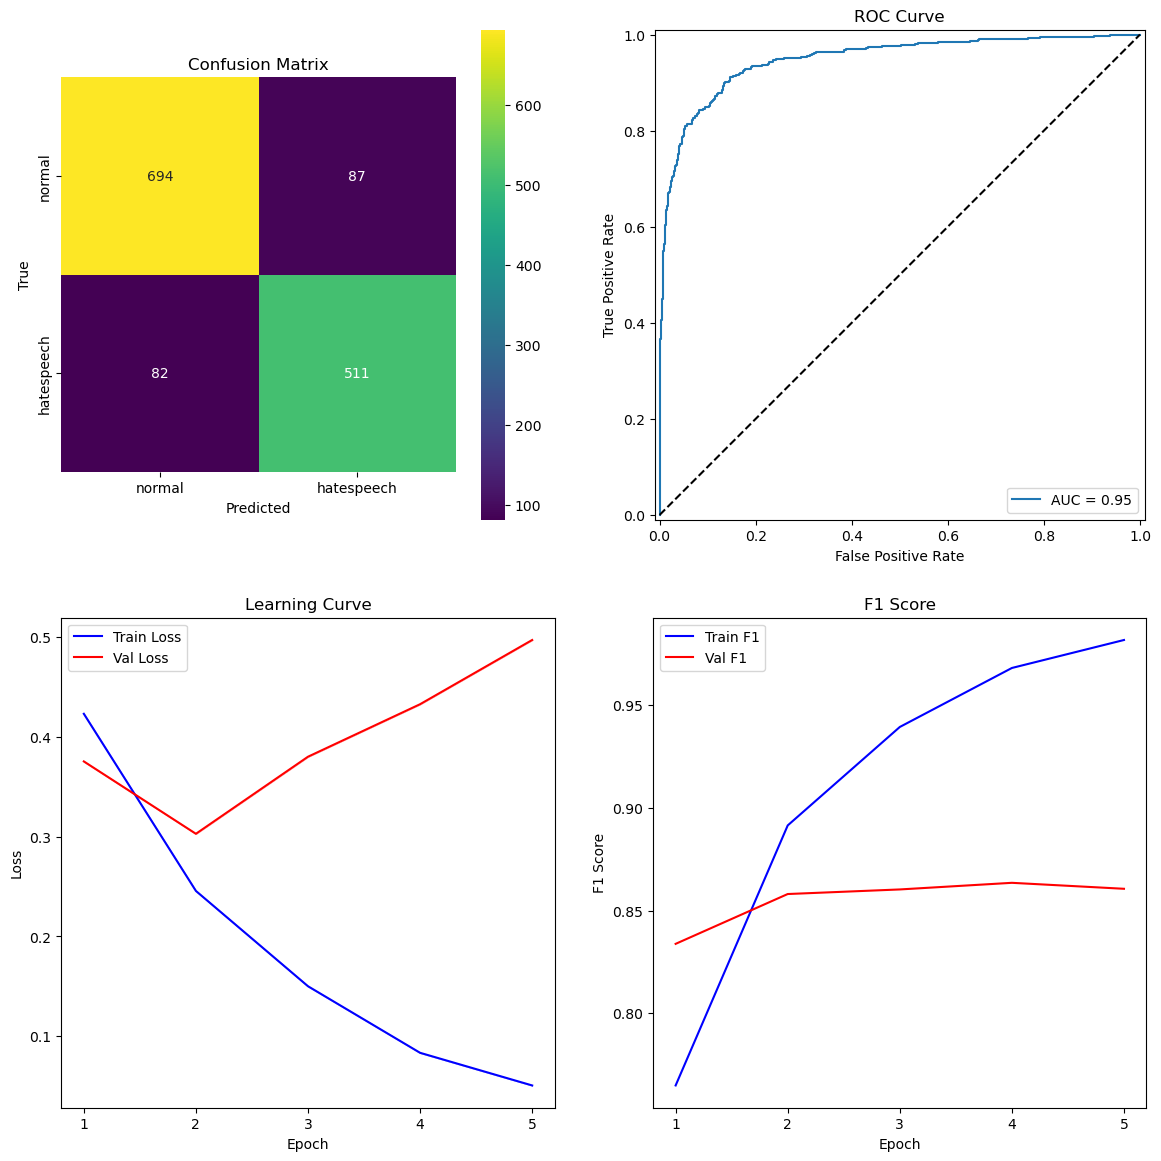

In [16]:
# Accuracy and classification report
fig, axs = plot_evaluation_report(
    correct,
    total,
    epochs,
    target_labels,
    all_predictions,
    all_labels,
    all_probabilities,
    train_losses,
    val_losses,
    train_f1_scores,
    val_f1_scores,
)


In [ ]:
# Free up the GPU memory
torch.cuda.empty_cache()



### 3. Evaluate XLnet

In [18]:
# Tokenization and encoding
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

# Add the "<user>" token to the tokenizer
tokenizer.add_tokens("<user>")

# The dataset has emojis present in the text. We need to parse them and add them to the tokenizer
emoji_list = [
    word for text in X_train + X_val + X_test for word in text if emoji.is_emoji(word)
]

# Add emojis to the tokenizer
for emoji_ in emoji_list:
    tokenizer.add_tokens(emoji_)

def encode(
    text_items: list[str],
    tokenizer: AutoTokenizer,
    max_length: int = 128,
) -> dict:
    """Encode the input text using the provided tokenizer."""
    return tokenizer(text_items,
                is_split_into_words=True,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt")


In [19]:
# Encode the training and validation datasets
X_train_encoded = encode(X_train, tokenizer)
X_val_encoded = encode(X_val, tokenizer)


In [20]:
# Data preparation
labels_train = torch.tensor(y_train)
labels_val = torch.tensor(y_val)

dataset_train = TensorDataset(
    X_train_encoded["input_ids"],
    X_train_encoded["attention_mask"],
    labels_train,
)

dataset_val = TensorDataset(
    X_val_encoded["input_ids"],
    X_val_encoded["attention_mask"],
    labels_val,
)

batch_size = 32
train_dataloader = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)



In [21]:
# Load the classification model
model_clf = AutoModelForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels=len(target_labels),
)

# Resize the token embeddings to account for the new "<user>" and emoji tokens
model_clf.resize_token_embeddings(len(tokenizer))

# Model configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clf.to(device)

if model_clf.device.type == "cuda":
    print("Successfully loaded the model to the GPU.")
else:
    print("WARNING: Could not load the model to the GPU. Using CPU instead.")


model_clf.config.label2id = label2id
model_clf.config.id2label = id2label

torch.multiprocessing.set_start_method("spawn", force=True)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded the model to the GPU.


In [ ]:
# Hyperparameters
learning_rate = 2.e-5
epochs = 5

optimizer = AdamW(model_clf.parameters(), lr=learning_rate, weight_decay=0.1)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps,
)


In [ ]:
# Training loop
train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
    model_clf,
    tokenizer,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    epochs=epochs,
    device=device,
    out_dir = RESULTS_DIR / "_xlnet-base-cased_2_classes",
    model_name="xlnet",
    monitor="loss",
)


Epoch 1/5:   0%|          | 0/387 [00:00<?, ?batch/s]

Epoch 1/5: 100%|██████████| 387/387 [04:35<00:00,  1.40batch/s, train_loss=0.474, val_loss=0.375, val_f1=0.836]


Validation loss improved from  inf to  0.375. Saving model...
Model saved to /home/marc/GitHub/MScThesisDS/msc_thesis_ds/.output/model_selection/_xlnet-base-cased_2_classes
Epoch 1/5 | Train Loss: 0.474497 | Train F1: 0.7109 | Val Loss: 0.374787 | Val F1: 0.8356



Epoch 2/5: 100%|██████████| 387/387 [04:37<00:00,  1.40batch/s, train_loss=0.295, val_loss=0.35, val_f1=0.847]


Validation loss improved from  0.375 to  0.350. Saving model...
Model saved to /home/marc/GitHub/MScThesisDS/msc_thesis_ds/.output/model_selection/_xlnet-base-cased_2_classes
Epoch 2/5 | Train Loss: 0.295150 | Train F1: 0.8616 | Val Loss: 0.350245 | Val F1: 0.8473



Epoch 3/5: 100%|██████████| 387/387 [04:37<00:00,  1.40batch/s, train_loss=0.225, val_loss=0.372, val_f1=0.841]


Validation loss did not improve from  0.350. Not saving model.
Epoch 3/5 | Train Loss: 0.224565 | Train F1: 0.8980 | Val Loss: 0.372473 | Val F1: 0.8415



Epoch 4/5: 100%|██████████| 387/387 [04:38<00:00,  1.39batch/s, train_loss=0.165, val_loss=0.445, val_f1=0.845]


Validation loss did not improve from  0.350. Not saving model.
Epoch 4/5 | Train Loss: 0.165414 | Train F1: 0.9301 | Val Loss: 0.444927 | Val F1: 0.8450



Epoch 5/5: 100%|██████████| 387/387 [04:38<00:00,  1.39batch/s, train_loss=0.13, val_loss=0.473, val_f1=0.839]

Validation loss did not improve from  0.350. Not saving model.
Epoch 5/5 | Train Loss: 0.130146 | Train F1: 0.9478 | Val Loss: 0.472769 | Val F1: 0.8394



In [24]:
# Load the best model
model_clf = AutoModelForSequenceClassification.from_pretrained(
    RESULTS_DIR / "xlnet-base-cased_2_classes",
    num_labels=len(target_labels),
)

model_clf.to(device)
if model_clf.device.type == "cuda":
    print("Successfully loaded the model to the GPU.")
else:
    print("WARNING: Could not load the model to the GPU. Using CPU instead.\nErrors may occur.")

# Evaluation of the model on the validation set
correct, total, all_predictions, all_labels, all_probabilities = evaluate_model(
    model_clf,
    val_dataloader,
    device=device,
)


Successfully loaded the model to the GPU.


Running validation: 100%|██████████| 43/43 [00:11<00:00,  3.82batch/s]


Validation Accuracy: 0.87
              precision    recall  f1-score   support

      normal      0.876     0.899     0.887       781
  hatespeech      0.862     0.833     0.847       593

    accuracy                          0.870      1374
   macro avg      0.869     0.866     0.867      1374
weighted avg      0.870     0.870     0.870      1374

ROC AUC: 0.9370


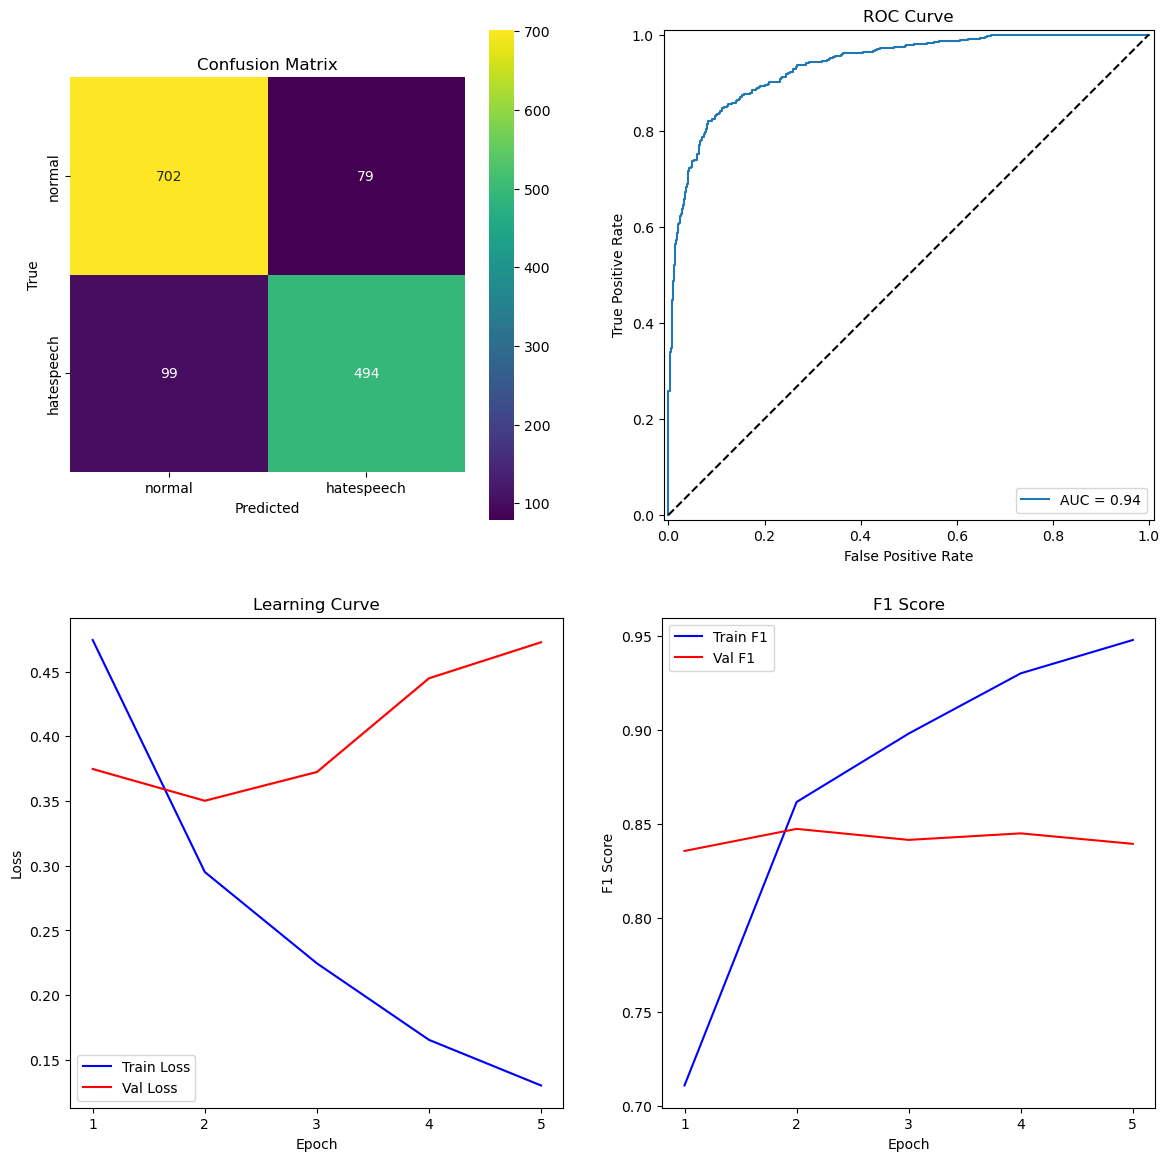

In [ ]:
# Accuracy and classification report
fig, axs = plot_evaluation_report(
    correct,
    total,
    epochs,
    target_labels,
    all_predictions,
    all_labels,
    all_probabilities,
    plot_learning_curves=True,
    train_losses=train_losses,
    val_losses=val_losses,
    train_f1_scores=train_f1_scores,
    val_f1_scores=val_f1_scores,
)

